# Merging of all datasets based on 'PaperId' columns

## Overview
Processing and merging of four different datasets based on the common identifier 'PaperId'. 
The goal is to consolidate information while avoiding duplication of key columns!

---

## Datasets Used:
- **'Initial_df'** → The primary dataset with extracted gene names (starting point for merging).
- **'Cancer_df'** → Contains additional cancer-related information.
- **'Treatment_df'** → Contains treatment-related information.
- **'Study_df'** → Contains study-related information.
- **'Variant_df'** → Contains extarcted variant information.
---

## Steps for merging
1. **Load the datasets** from CSV files.
2. **Identify and ignore redundant columns** in `cancer_df`, `treatment_df`, and `study_df`:
   - Columns like `PaperTitle`, `Author`, `Abstract`, `Citations`, `PubDate`, `PubYear`, `CoFoS`, or `ID` (already in `Initial_df`) are dropped.
3. **Merge all datasets** on `PaperId` using a left join (keeping all records from `Initial_df`).
4. **Check for duplicate column names** after merging to avoid redundancy.
5. **Print a summary** of the final merged dataset, including its shape and column names.

# 1) Set up libraries and datasets

## 1.1) Import libraries and models

In [2]:
#Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
import time
import datetime
import re
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
print("Success!")

2025-04-20 21:47:42.135543: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 21:47:42.152685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745178462.170660  837883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745178462.176102  837883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 21:47:42.196099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Success!


## 1.2) Load datasets

In [3]:
# Define directories
base_dir = "/data/JH/marie/TrendyVariants"
input_dir = os.path.join(base_dir, "Input")
output_dir = os.path.join(base_dir, "Output")
LLM_variant_dir = os.path.join(output_dir, "LLM_variant_analysis")
coassociation_dir = os.path.join(output_dir, "coassociation_analysis")
classifier_dir = os.path.join(output_dir, "gc_batch_files")
variantscape_dir = os.path.join(output_dir, "Variantscape_analysis")

# Confirm current working directory
os.chdir(output_dir)
print("Current directory:", os.getcwd())

# Load datasets
# Input directory files
ESCAT_genes = pd.read_csv(os.path.join(input_dir, "ESCAT_pc_genes.csv"), header=None)
oncomine_genes = pd.read_csv(os.path.join(input_dir, "oncomine_ngs_panel.csv"), header=None)

# Output directory files
initial_df = pd.read_csv(os.path.join(output_dir, "cleaned_BioBERT_data.csv"))
cancer_df = pd.read_csv(os.path.join(output_dir, "binary_cancer_matrix_filtered.csv"))
treatment_df = pd.read_csv(os.path.join(output_dir, "filtered_treatment_mapping_with_matches.csv"))

# Classifier directory file
study_df = pd.read_csv(os.path.join(classifier_dir, "final_gc_classificaton_output_199726.csv"))

# Variant directory file
variant_df = pd.read_csv(os.path.join(LLM_variant_dir, "normalized_merged_variant_matrix_v4.csv"))

print("Success!")

Current directory: /data/JH/marie/TrendyVariants/Output
Success!


In [228]:
# Investigate datasets
os.chdir(output_directory)
print("\nDataset Lengths:")
print(f"-Initial dataset: {len(initial_df):,}")
print(f"-Cancer type dataset: {len(cancer_df):,}")
print(f"-Treatment dataset: {len(treatment_df):,}")
print(f"-Study design dataset: {len(study_df):,}")
print(f"-Variant dataset: {len(variant_df):,}")
print("\nNumber of ESCAT genes:", len(ESCAT_genes))
print("Number of oncomine genes:", len(oncomine_genes))

# Check if all datasets have the same length
dataset_lengths = [len(initial_df), len(cancer_df), len(treatment_df), len(study_df),len(variant_df)]


Dataset Lengths:
-Initial dataset: 308,748
-Cancer type dataset: 199,726
-Treatment dataset: 126,195
-Study design dataset: 199,726
-Variant dataset: 16,508

Number of ESCAT genes: 6
Number of oncomine genes: 161


In [368]:
# Investigate cancer of unkonwn primary origin
column_name = "cancer of unknown primary origin"
if column_name in cancer_df.columns:
    paper_ids_with_unknown_primary = cancer_df[cancer_df[column_name] == 1]['PaperId'].tolist()
    print(f"Found {len(paper_ids_with_unknown_primary)} PaperIds where '{column_name}' is 1.")
    print(f"PaperIds: {paper_ids_with_unknown_primary}")
    matching_treatment_rows = treatment_df[treatment_df['PaperId'].isin(paper_ids_with_unknown_primary)]
    if not matching_treatment_rows.empty:
        print("\nRows in treatment_df with matching PaperIds:")
        print(matching_treatment_rows)

        for column in matching_treatment_rows.columns:
            if column != 'PaperId': 
                if matching_treatment_rows[column].dtype == 'object':
                    count_ones = (matching_treatment_rows[column] == '1').sum()
                else:
                    count_ones = (matching_treatment_rows[column] == 1).sum()
                if count_ones > 0:
                    print(f"Column '{column}' has {count_ones} '1's in matching PaperIds")
        matching_variant_rows = variant_df[variant_df['PaperId'].isin(paper_ids_with_unknown_primary)]

        if not matching_variant_rows.empty:
            print("\nRows in variant_df with matching PaperIds:")
            print(matching_variant_rows)
        else:
            print("\nNo matching PaperIds found in variant_df.")
    else:
        print("\nNo matching PaperIds found in treatment_df.")
else:
    print(f"The column '{column_name}' does not exist in 'cancer_df'.")

Found 2 PaperIds where 'cancer of unknown primary origin' is 1.
PaperIds: ['4379336282', '2546914043']

Rows in treatment_df with matching PaperIds:
          PaperId                                         PaperTitle  \
99116  2546914043  phase i study of gdc-0425, a checkpoint kinase...   

                                               Citations  \
99116  1521031009|1594035260|1644377522|1967880683|19...   

                                                   CoFoS  \
99116  2780258809|2777063308|71924100|2778375690|2780...   

                                                 Authors  \
99116  Jeffrey R. Infante, Antoine Hollebecque, Sophi...   

                                                Abstract Language  PubYear  \
99116  purpose: chk1 inhibition potentiates dna-damag...       en     2016   

          PubDate      BioBERT  ...  Vorasidenib  Vorinostat  WHI-P154  \
99116  2016-11-05  CHEK1, TP53  ...            0           0         0   

       WYE354  WZ4002  Zenocutuzumab-

# 2) Merging of datasets

In [233]:
# Ensure all 'PaperId' columns are strings
initial_df["PaperId"] = initial_df["PaperId"].astype(str)
cancer_df["PaperId"] = cancer_df["PaperId"].astype(str)
treatment_df["PaperId"] = treatment_df["PaperId"].astype(str)
study_df["PaperId"] = study_df["PaperId"].astype(str)
variant_df["PaperId"] = variant_df["PaperId"].astype(str)

# Get the set of valid PaperIds from the variant_df
valid_paper_ids = set(variant_df['PaperId'])

# Function to filter a dataset by valid PaperIds
def filter_by_variant_ids(df, df_name):
    if "PaperId" not in df.columns:
        print(f"'PaperId' column not found in {df_name}. Skipping filtering.")
        return df

    initial_count = len(df)
    df_subset = df[df['PaperId'].isin(valid_paper_ids)]
    final_count = len(df_subset)
    
    print(f"{df_name}: Filtered from {initial_count:,} rows to {final_count:,} rows.")
    return df_subset

# Apply filtering to each dataset
initial_df_subset = filter_by_variant_ids(initial_df, "Initial_df")
cancer_df_subset = filter_by_variant_ids(cancer_df, "Cancer_df")
treatment_df_subset = filter_by_variant_ids(treatment_df, "Treatment_df")
study_df_subset = filter_by_variant_ids(study_df, "Study_df")

# Investigate filtered datasets
print("\nFiltered Dataset Lengths:")
print(f"-Initial dataset subset: {len(initial_df_subset):,}")
print(f"-Cancer type dataset subset: {len(cancer_df_subset):,}")
print(f"-Treatment dataset subset: {len(treatment_df_subset):,}")
print(f"-Study design dataset subset: {len(study_df_subset):,}")
print(f"-Variant dataset (reference): {len(variant_df):,}")

Initial_df: Filtered from 308,748 rows to 16,508 rows.
Cancer_df: Filtered from 199,726 rows to 16,508 rows.
Treatment_df: Filtered from 126,195 rows to 7,524 rows.
Study_df: Filtered from 199,726 rows to 16,508 rows.

Filtered Dataset Lengths:
-Initial dataset subset: 16,508
-Cancer type dataset subset: 16,508
-Treatment dataset subset: 7,524
-Study design dataset subset: 16,508
-Variant dataset (reference): 16,508


In [234]:
# Convert oncomine_genes to a set for fast lookups
oncomine_genes_set = set(oncomine_genes[0])
columns_to_remove = oncomine_genes_set.union({"Sum_Gene_Mentions"})
cancer_cols_to_drop = [col for col in cancer_df_subset.columns if col in columns_to_remove or "BioBERT" in col]
treatment_cols_to_drop = [col for col in treatment_df_subset.columns if col in columns_to_remove or "BioBERT" in col]

# Drop columns from cancer_df_subset
cancer_df_subset = cancer_df_subset.drop(columns=cancer_cols_to_drop, errors='ignore')

# Drop columns from treatment_df_subset
treatment_df_subset = treatment_df_subset.drop(columns=treatment_cols_to_drop, errors='ignore')
print(f"\nRemoved from cancer_df_subset: {len(cancer_cols_to_drop)} columns")
print(f"Removed from treatment_df_subset: {len(treatment_cols_to_drop)} columns")
print("Columns removed due to:")
print("- Oncomine Genes")
print("- Sum_Gene_Mentions")
print("- Columns containing 'BioBERT'")


Removed from cancer_df_subset: 163 columns
Removed from treatment_df_subset: 163 columns
Columns removed due to:
- Oncomine Genes
- Sum_Gene_Mentions
- Columns containing 'BioBERT'


In [304]:
os.chdir(variantscape_directory)
output_file = "merged_detected_variant_df.csv"
initial_row_counts = {
    "initial_df": len(initial_df_subset),
    "cancer_df_rem": len(cancer_df_rem),
    "treatment_df_rem": len(treatment_df_rem),
    "study_df_rem": len(study_df_rem),
    "variant_df_rem": len(variant_df_rem)
}

# Initialize the merged DataFrame with the initial dataset
merged_df = initial_df_subset.copy()
column_sources = {col: "Initial df" for col in initial_df_subset.columns}

datasets_to_merge = [
    (cancer_df_rem, "Cancer"),
    (treatment_df_rem, "Treatment"),
    (study_df_rem, "Study"),
    (variant_df_rem, "Variant")
]

# Merge datasets with progress bar
print("\nStarting the merging process...")
for df, name in tqdm(datasets_to_merge, desc="Merging datasets", unit="dataset"):
    if "PaperId" in df.columns:
        for col in df.columns:
            if col != "PaperId" and col not in column_sources:
                column_sources[col] = name  
        merged_df = pd.merge(merged_df, df, on="PaperId", how="outer", suffixes=("", f"_{name}"))
    else:
        print(f"'PaperId' column missing in {name}, skipping merge.")

# Ensure consistent formatting for numeric columns
print("\nConverting numeric columns...")
numeric_columns = [col for col in merged_df.columns if pd.api.types.is_numeric_dtype(merged_df[col])]

for col in tqdm(numeric_columns, desc="Converting numeric columns", unit="column"):
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').fillna(0).astype(int)

# Add the source row at the top *after* merging
source_row = pd.Series(column_sources, name='Source_Row')
merged_df = pd.concat([pd.DataFrame([source_row]), merged_df], ignore_index=True)
print("\nFirst 5 rows of merged dataset:")
print(merged_df.head())

# -----------------------------------
# Check for Duplicate Column Names
# -----------------------------------
print("\nChecking for duplicate column names...")
duplicate_columns = merged_df.columns[merged_df.columns.duplicated()].unique()

if len(duplicate_columns) > 0:
    print(f"\nDuplicate column names found ({len(duplicate_columns):,}):")
    for col in tqdm(duplicate_columns, desc="Reporting duplicates", unit="column"):
        print(col)
else:
    print("No duplicate column names found.")

# Print final results
print("\nMerging completed successfully.")
print(f"Final dataset shape: {merged_df.shape[0]:,} rows, {merged_df.shape[1]:,} columns")
print("\nFirst 10 rows of merged dataset:")
print(merged_df.head(10))



Starting the merging process...


Merging datasets: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78dataset/s]



Converting numeric columns...


Converting numeric columns: 100%|████████████████████████████████████████████████| 12905/12905 [00:07<00:00, 1623.98column/s]



First 5 rows of merged dataset:
      PaperId                                         PaperTitle  \
0  Initial df                                         Initial df   
1   100806778   MEK + CDK4 a regimen for non-BRAF V6000 melanoma   
2  1026807214  INFEKSI Human papillomavirus (HPV) 16/18 DAN K...   
3  1027363092  RET polymorphisms might be the risk factors fo...   
4   103311626  Dietary Flavonoids, Polymorphisms of the Perox...   

                                           Citations  \
0                                         Initial df   
1                                                NaN   
2                                                NaN   
3  1964830485|1975782735|1979838547|1982660784|19...   
4  1968217868|1989331925|1989428273|1992451705|19...   

                                               CoFoS  \
0                                         Initial df   
1  21790070|2780265364|2777658100|2778472372|5029...   
2  135763542|2778580637|36823959|2994532551|61511... 

In [287]:
# Print final results
print("\nMerging completed. Final dataset shape:", f"{merged_df.shape[0]:,} rows, {merged_df.shape[1]:,} columns")
print("Columns in final dataset:", merged_df.columns.tolist())
print("\nFirst 10 rows of merged dataset:")
print(merged_df.head(10))


Merging completed. Final dataset shape: 16,509 rows, 12,925 columns
Columns in final dataset: ['PaperId', 'PaperTitle', 'Citations', 'CoFoS', 'Authors', 'Abstract', 'Language', 'PubYear', 'PubDate', 'BioBERT', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'AR', 'ARAF', 'ARID1A', 'ATM', 'ATR', 'ATRX', 'AXL', 'BAP1', 'BRAF', 'BRCA1', 'BRCA2', 'BTK', 'CBL', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CDK12', 'CDK2', 'CDK4', 'CDK6', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CHEK1', 'CHEK2', 'CREBBP', 'CSF1R', 'CTNNB1', 'DDR2', 'EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2', 'ERG', 'ESR1', 'ETV1', 'ETV4', 'ETV5', 'EZH2', 'FANCA', 'FANCD2', 'FANCI', 'FBXW7', 'FGF19', 'FGF3', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FGR', 'FLT3', 'FOXL2', 'GATA2', 'GNA11', 'GNAQ', 'GNAS', 'H3F3A', 'HIST1H3B', 'HNF1A', 'HRAS', 'IDH1', 'IDH2', 'IGF1R', 'JAK1', 'JAK2', 'JAK3', 'KDR', 'KIT', 'KNSTRN', 'KRAS', 'MAGOH', 'MAP2K1', 'MAP2K2', 'MAP2K4', 'MAPK1', 'MAX', 'MDM2', 'MDM4', 'MED12', 'MET', 'MLH1', 'MRE11', 'MSH2', 'MSH6', 'MTOR', 'MYB', 'MYBL1', '

In [310]:
# Define the columns relevant to all_conditions
columns_of_interest = [
    "Sum_Gene_Mentions", "Cancer_Type_Sum", "Sum_treatments", "total_variant_count", "Study_design"
]

print("\nFirst 5 rows of merged_df with relevant columns:")
print(merged_df[columns_of_interest].head())
print(merged_df.shape)


First 5 rows of merged_df with relevant columns:
  Sum_Gene_Mentions Cancer_Type_Sum Sum_treatments total_variant_count  \
0        Initial df          Cancer      Treatment             Variant   
1                 7               1              4                   2   
2                 1               1              0                   1   
3                 1               1              0                   3   
4                 1               1              0                   4   

              Study_design  
0                    Study  
1           Clinical study  
2           Clinical study  
3           Clinical study  
4  Observational/RWE study  
(16509, 12925)


In [357]:
# Replace 'Cancer_of_Primary_Unknown' with the actual column name
column_name = "cancer of unknown primary origin"

# Check if the column exists
if column_name in merged_df.columns:
    count_1 = (merged_df[column_name] == 1).sum() 
    count_0 = (merged_df[column_name] == 0).sum() 

    print(f"Count of '1' in '{column_name}': {count_1}")
    print(f"Count of '0' in '{column_name}': {count_0}")
else:
    print(f"The column '{column_name}' does not exist in the DataFrame.")

Count of '1' in 'cancer of unknown primary origin': 0
Count of '0' in 'cancer of unknown primary origin': 16508


In [342]:
# Save dataset as CSV with progress bar (as it is huge, this takes about 1h)
os.chdir(variantscape_directory)
file_name = "final_merged_df.csv"
chunk_size = 5_000  
total_rows = len(merged_df)

with open(file_name, "w", encoding="utf-8", newline='') as f:
    merged_df.head(0).to_csv(f, index=False) 
    
    # Progress bar for writing rows in chunks
    with tqdm(total=total_rows, desc="Saving CSV", unit=" rows", bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:
        for i in range(0, total_rows, chunk_size):
            chunk = merged_df.iloc[i:i + chunk_size]
            chunk.to_csv(f, index=False, header=False, mode='a')
            pbar.update(len(chunk))

print("\nMerged dataframe successfully saved.")
print(f"Total Rows: {total_rows:,}")
print(f"Total Columns: {len(merged_df.columns):,}")
print(f"File Saved: {file_name}")

Saving CSV: 100%|██████████████████████████████████████████████████████████████████████████████████ 16509/16509 [10:54<00:00]


Merged dataframe successfully saved.
Total Rows: 16,509
Total Columns: 12,925
File Saved: final_merged_df.csv


In [322]:
# Ensure numeric types (without modifying anything)
cols_to_check = ["Sum_Gene_Mentions", "Cancer_Type_Sum", "Sum_treatments", "total_variant_count"]

# Count rows where value is >= 1 for each column, ignoring index 0
counts_ge1 = (merged_df.iloc[1:][cols_to_check] >= 1).sum()

# Count non-empty 'Study_design' values (not null, not '0', not numeric 0), excluding index 0
study_design_non_empty = merged_df.iloc[1:]["Study_design"].notna() & (merged_df.iloc[1:]["Study_design"] != "0") & (merged_df.iloc[1:]["Study_design"] != 0)
count_study_design = study_design_non_empty.sum()
all_conditions = (
    (merged_df.iloc[1:]["Sum_Gene_Mentions"] >= 1) &
    (merged_df.iloc[1:]["Cancer_Type_Sum"] >= 1) &
    (merged_df.iloc[1:]["Sum_treatments"] >= 1) &
    (merged_df.iloc[1:]["total_variant_count"] >= 1) &
    study_design_non_empty
)
count_all_conditions = all_conditions.sum()
print("\nNumber of rows with values ≥ 1 (ignoring index 0):")
for col, count in counts_ge1.items():
    print(f"- {col}: {count:,}")

print(f"- Study_design (not empty or 0): {count_study_design:,}")
print(f"- All conditions TRUE (ignoring index 0): {count_all_conditions:,}")


Number of rows with values ≥ 1 (ignoring index 0):
- Sum_Gene_Mentions: 16,508
- Cancer_Type_Sum: 16,508
- Sum_treatments: 7,524
- total_variant_count: 16,508
- Study_design (not empty or 0): 16,508
- All conditions TRUE (ignoring index 0): 7,524


In [328]:
# Combine all conditions (ignoring index 0)
all_conditions = (
    (merged_df.iloc[1:]["Sum_Gene_Mentions"] >= 1) &
    (merged_df.iloc[1:]["Cancer_Type_Sum"] >= 1) &
    (merged_df.iloc[1:]["Sum_treatments"] >= 1) &
    (merged_df.iloc[1:]["total_variant_count"] >= 1)
)

# Get the subset of rows where all conditions are true, ignoring index 0
filtered_subset = merged_df.iloc[1:][all_conditions].copy()
if 'PaperId' in filtered_subset.columns:
    print("The column 'PaperId' is present in the filtered DataFrame.")
else:
    print("The column 'PaperId' is not present in the filtered DataFrame.")
filtered_subset_with_index_0 = pd.concat([merged_df.iloc[[0]], filtered_subset])
print(f"\nShape of the filtered DataFrame (with index 0): {filtered_subset_with_index_0.shape}")
print(filtered_subset_with_index_0.head())
print(f"Final shape of the filtered DataFrame: {filtered_subset_with_index_0.shape}")
filtered_subset_with_index_0.to_csv('filtered_subset_with_index_0.csv', index=False)
print("Filtered DataFrame has been saved as 'filtered_subset_with_index_0.csv'.")

The column 'PaperId' is present in the filtered DataFrame.

Shape of the filtered DataFrame (with index 0): (7525, 12925)
       PaperId                                         PaperTitle  \
0   Initial df                                         Initial df   
1    100806778   MEK + CDK4 a regimen for non-BRAF V6000 melanoma   
9   1139842342  Efficacy of Imatinib in Patients with Platelet...   
12  1188743767  Genetic variations in the mTOR gene contribute...   
13  1201445172  Therapeutic effects of the bromodomain inhibit...   

                                            Citations  \
0                                          Initial df   
1                                                 NaN   
9   1965027830|2015015957|2025142513|2025447556|20...   
12  1965766554|1971870911|1973296923|1974942240|19...   
13                                                NaN   

                                                CoFoS  \
0                                          Initial df   
1   21

KeyboardInterrupt: 

In [352]:
# Original dataset lengths for reference
original_lengths = {
    "Initial Dataset": len(initial_df),
    "Cancer Type Dataset": len(cancer_df),
    "Study Design Dataset": len(study_df),
    "Treatment Dataset": len(treatment_df),
    "Variant Dataset": len(variant_df)
}

print("\nOriginal Dataset Lengths (with percentage of initial dataset):")
for name, length in original_lengths.items():
    percentage = (length / original_lengths["Initial Dataset"]) * 100
    print(f"- {name}: {length:,} ({percentage:.2f}%)")

percentage_all_conditions = (count_all_conditions / original_lengths["Initial Dataset"]) * 100
print(f"\n- All conditions TRUE: {count_all_conditions:,} ({percentage_all_conditions:.2f}%)")

labels = [
    "Initial Dataset", "Cancer Type Dataset", "Study Design Dataset", 
    "Treatment Dataset", "Variant Dataset", "All conditions TRUE"
]

counts = list(original_lengths.values()) + [count_all_conditions]
percentages = [(count / original_lengths["Initial Dataset"]) * 100 for count in counts]
dataset_lengths_df = pd.DataFrame({
    "Category": labels,
    "Count": counts,
    "Percentage": percentages
})

csv_file_path = "conditional_filterting_of_final_datasets_for_coassciaitions_analysis.csv"
dataset_lengths_df.to_csv(csv_file_path, index=False)
print(f"\nData successfully saved to: {csv_file_path}")


Original Dataset Lengths (with percentage of initial dataset):
- Initial Dataset: 308,748 (100.00%)
- Cancer Type Dataset: 199,726 (64.69%)
- Study Design Dataset: 199,726 (64.69%)
- Treatment Dataset: 126,195 (40.87%)
- Variant Dataset: 16,508 (5.35%)

- All conditions TRUE: 7,524 (2.44%)

Data successfully saved to: conditional_filterting_of_final_datasets_for_coassciaitions_analysis.csv


## Create figure

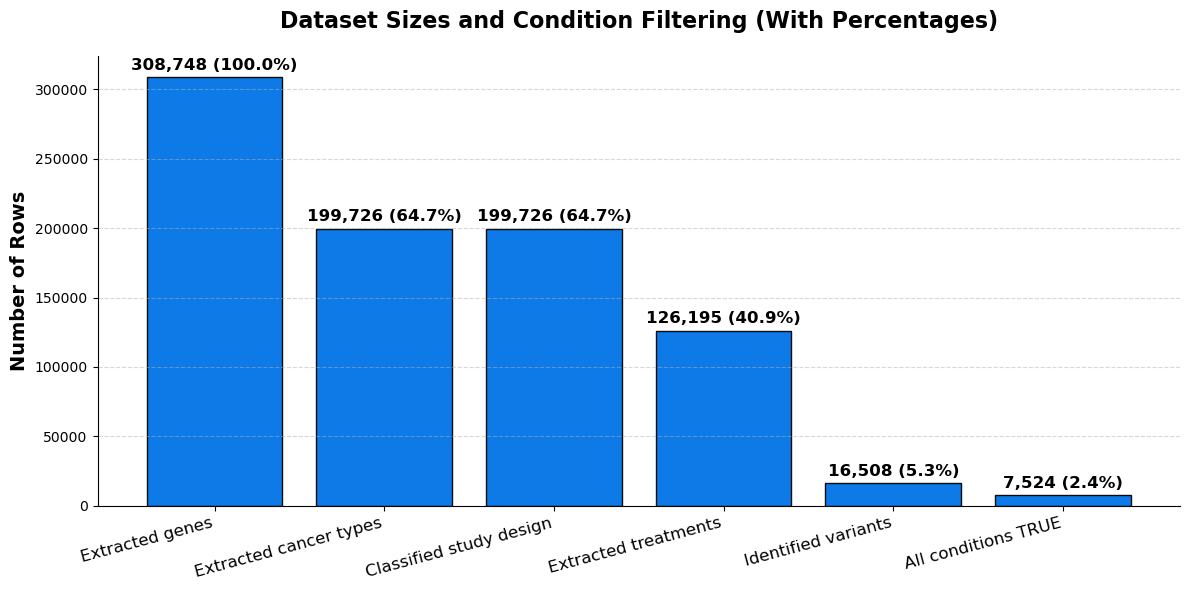

In [326]:
# Original dataset lengths for reference
original_lengths = {
    "Initial Dataset": len(initial_df),
    "Cancer Type Dataset": len(cancer_df),
    "Treatment Dataset": len(treatment_df),
    "Study Design Dataset": len(study_df),
    "Variant Dataset": len(variant_df)
}

# Counts from original datasets
count_1 = original_lengths["Initial Dataset"]
count_2 = original_lengths["Cancer Type Dataset"]
count_3 = original_lengths["Study Design Dataset"]
count_4 = original_lengths["Treatment Dataset"]
count_5 = original_lengths["Variant Dataset"]
count_all_conditions = count_all_conditions

labels = [
    "Extracted genes",
    "Extracted cancer types",
    "Classified study design", 
    "Extracted treatments",   
    "Identified variants",
    "All conditions TRUE"
]

counts = [count_1, count_2, count_3, count_4, count_5, count_all_conditions]
percentages = [(count / count_1 * 100) if count_1 > 0 else 0 for count in counts]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(labels, counts, color="#0073e6", edgecolor='black', alpha=0.95) 

for bar, count, pct in zip(bars, counts, percentages):
    label = f"{count:,} ({pct:.1f}%)"
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(counts) * 0.01,
            label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title("Dataset Sizes and Condition Filtering (With Percentages)", fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel("Number of Rows", fontsize=14, fontweight='bold')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=12, ha="right", rotation=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## =====================================================

In [329]:
first_row = filtered_subset_with_index_0.iloc[0]
unique_values = first_row.unique()
print("Unique values in the first row:")
print(unique_values)

# Find columns where the value is NaN
nan_columns = first_row[first_row.isna()].index.tolist()
print("\n\nColumns with NaN in the first row:")
for col in nan_columns:
    print(f"- {col}")

Unique values in the first row:
['Initial df' 'Cancer' 'Treatment' 'Study' 'Variant']


Columns with NaN in the first row:


In [330]:
# Check changes
columns_of_interest = ["Sum_Gene_Mentions", "Cancer_Type_Sum", "Sum_treatments", "total_variant_count"]
print("Rows from selected columns:")
print(filtered_subset_with_index_0[columns_of_interest].head(10))

Rows from selected columns:
   Sum_Gene_Mentions Cancer_Type_Sum Sum_treatments total_variant_count
0         Initial df          Cancer      Treatment             Variant
1                  7               1              4                   2
9                  1               1              1                   1
12                 1               1              1                   4
13                 1               1              2                   2
18                 1               1              1                   3
19                 1               1              4                   2
20                 3               1              3                   3
22                 4               1              1                   1
23                 1               1              1                   2


In [345]:
# Save the updated and filtered dataset to CSV
merged_detected_variant_df=filtered_subset_with_index_0.copy()
output_file = "merged_detected_variant_df.csv"
merged_detected_variant_df.to_csv(output_file, index=False)
print(f"Filtered dataset saved as '{output_file}'")

Filtered dataset saved as 'merged_detected_variant_df.csv'


In [332]:
rows_before_col_drop=len(merged_detected_variant_df)
col_before_col_drop=len(merged_detected_variant_df.columns)
print(f"Total rows: {rows_before_col_drop:,}")
print(f"Total columns: {col_before_col_drop:,}")

Total rows: 7,525
Total columns: 12,925


In [ ]:
## Drop the COLUMNS as well where the variant sum is ZERO!

In [335]:
print(merged_detected_variant_df.columns.tolist())

['PaperId', 'PaperTitle', 'Citations', 'CoFoS', 'Authors', 'Abstract', 'Language', 'PubYear', 'PubDate', 'BioBERT', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'AR', 'ARAF', 'ARID1A', 'ATM', 'ATR', 'ATRX', 'AXL', 'BAP1', 'BRAF', 'BRCA1', 'BRCA2', 'BTK', 'CBL', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CDK12', 'CDK2', 'CDK4', 'CDK6', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CHEK1', 'CHEK2', 'CREBBP', 'CSF1R', 'CTNNB1', 'DDR2', 'EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2', 'ERG', 'ESR1', 'ETV1', 'ETV4', 'ETV5', 'EZH2', 'FANCA', 'FANCD2', 'FANCI', 'FBXW7', 'FGF19', 'FGF3', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FGR', 'FLT3', 'FOXL2', 'GATA2', 'GNA11', 'GNAQ', 'GNAS', 'H3F3A', 'HIST1H3B', 'HNF1A', 'HRAS', 'IDH1', 'IDH2', 'IGF1R', 'JAK1', 'JAK2', 'JAK3', 'KDR', 'KIT', 'KNSTRN', 'KRAS', 'MAGOH', 'MAP2K1', 'MAP2K2', 'MAP2K4', 'MAPK1', 'MAX', 'MDM2', 'MDM4', 'MED12', 'MET', 'MLH1', 'MRE11', 'MSH2', 'MSH6', 'MTOR', 'MYB', 'MYBL1', 'MYC', 'MYCL', 'MYCN', 'MYD88', 'NBN', 'NF1', 'NF2', 'NFE2L2', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'NO

In [336]:
# Load or use existing dataframe
if 'merged_detected_variant_df' not in globals():
    merged_detected_variant_df = pd.read_csv("merged_detected_variant_df.csv")

# Drop 'Unnamed: 0' if it exists — this was likely the index when saved
if "Unnamed: 0" in merged_detected_variant_df.columns:
    print("Dropping 'Unnamed: 0' — it was likely saved as index.")
    merged_detected_variant_df = merged_detected_variant_df.drop(columns=["Unnamed: 0"])

# Copy for processing
rem_col_variant_df = merged_detected_variant_df.copy()

# Manually defined columns to ignore
ignore_columns = {
    'PaperId', 'PaperTitle', 'Citations', 'CoFoS', 'Authors', 'Abstract', 
    'Language', 'PubYear', 'PubDate', 'BioBERT', 'Sum_Gene_Mentions', 
    'Extracted_Cancer_Terms_old', 'Extracted_Cancer_Terms','Cancer_Type_Sum',
    'Mapped_Cancer_Terms', 'Unmatched_Cancer_Terms', 'Remapped_Cancer_Terms', 
    'Final_Mapped_Cancer_Terms', 'Treatment_matches', 'Sum_treatments', 'Study_design',
    'total_variant_count','LLM_Prompt', 'LLM_Response', 'Cleaned_Variant_Gene_Pairs'
}

# Additional prefixes to ignore
ignore_prefixes = ('Gene_', 'Variant_', 'LLM_Prompt', 'LLM_Response')

# Add any column starting with those prefixes to the ignore list
for col in rem_col_variant_df.columns:
    if col.startswith(ignore_prefixes):
        ignore_columns.add(col)

# Identify candidate binary columns (not ignored)
candidate_cols = [col for col in rem_col_variant_df.columns if col not in ignore_columns]

# Exclude row 0 (metadata row)
data_for_analysis = rem_col_variant_df.iloc[1:].copy()

# Convert to numeric and normalize values
data_for_analysis[candidate_cols] = data_for_analysis[candidate_cols].apply(pd.to_numeric, errors='coerce')
data_for_analysis[candidate_cols] = data_for_analysis[candidate_cols].astype('Int64')

# Check that candidate columns only contain 0s and 1s
non_binary_columns = []
print("Checking for non-binary values (0/1 only)...")
for col in tqdm(candidate_cols, desc="Validating columns", unit="col"):
    unique_vals = data_for_analysis[col].dropna().unique()
    if not all(val in [0, 1] for val in unique_vals):
        non_binary_columns.append((col, unique_vals.tolist()))

# Print result
if non_binary_columns:
    print(f"{len(non_binary_columns)} column(s) (excluding ignored and row 0) contain values other than 0 or 1.")
    print("First 5:")
    for col, vals in non_binary_columns[:5]:
        print(f"- {col}: {vals}")
else:
    print("All candidate columns contain only 0s and 1s (excluding row 0).")

Checking for non-binary values (0/1 only)...


Validating columns: 100%|███████████████████████████████████████████████████████████| 12900/12900 [00:04<00:00, 3031.64col/s]

All candidate columns contain only 0s and 1s (excluding row 0).


In [337]:
# Get all binary-valid columns by removing the ones with non-binary values
binary_columns = [col for col in candidate_cols if col not in [c[0] for c in non_binary_columns]]
print(f"\nBinary columns (total: {len(binary_columns)}):\n")
for col in binary_columns:
    print(col)


Binary columns (total: 12900):

AKT1
AKT2
AKT3
ALK
AR
ARAF
ARID1A
ATM
ATR
ATRX
AXL
BAP1
BRAF
BRCA1
BRCA2
BTK
CBL
CCND1
CCND2
CCND3
CCNE1
CDK12
CDK2
CDK4
CDK6
CDKN1B
CDKN2A
CDKN2B
CHEK1
CHEK2
CREBBP
CSF1R
CTNNB1
DDR2
EGFR
ERBB2
ERBB3
ERBB4
ERCC2
ERG
ESR1
ETV1
ETV4
ETV5
EZH2
FANCA
FANCD2
FANCI
FBXW7
FGF19
FGF3
FGFR1
FGFR2
FGFR3
FGFR4
FGR
FLT3
FOXL2
GATA2
GNA11
GNAQ
GNAS
H3F3A
HIST1H3B
HNF1A
HRAS
IDH1
IDH2
IGF1R
JAK1
JAK2
JAK3
KDR
KIT
KNSTRN
KRAS
MAGOH
MAP2K1
MAP2K2
MAP2K4
MAPK1
MAX
MDM2
MDM4
MED12
MET
MLH1
MRE11
MSH2
MSH6
MTOR
MYB
MYBL1
MYC
MYCL
MYCN
MYD88
NBN
NF1
NF2
NFE2L2
NOTCH1
NOTCH2
NOTCH3
NOTCH4
NRAS
NRG1
NTRK1
NTRK2
NTRK3
NUTM1
PALB2
PDGFRA
PDGFRB
PIK3CA
PIK3CB
PIK3R1
PMS2
POLE
PPARG
PPP2R1A
PRKACA
PRKACB
PTCH1
PTEN
PTPN11
RAC1
RAD50
RAD51
RAD51B
RAD51C
RAD51D
RAF1
RB1
RELA
RET
RHEB
RHOA
RICTOR
RNF43
ROS1
RSPO2
RSPO3
SETD2
SF3B1
SLX4
SMAD4
SMARCA4
SMARCB1
SMO
SPOP
SRC
STAT3
STK11
TERT
TOP1
TP53
TSC1
TSC2
U2AF1
XPO1
acinic cell cancer
acral lentiginous melanoma
acute basophilic l

In [338]:
# Drop 0 columns
# Only proceed if all binary columns are valid
if not non_binary_columns:
    steps = [
        "Check which binary columns are all-zero (excluding row 0)",
        "Print summary",
        "Drop all-zero binary columns",
        "Save cleaned DataFrame"
    ]
    pbar = tqdm(total=len(steps), desc="Processing", bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}]')

    # Compute column sums (excluding row 0)
    col_sums = data_for_analysis[candidate_cols].sum()
    cols_all_zero = col_sums[col_sums == 0].index.tolist()
    cols_with_ones = col_sums[col_sums > 0].index.tolist()
    pbar.update(1)
    total = len(candidate_cols)
    num_zero = len(cols_all_zero)
    num_one = len(cols_with_ones)
    pct_one = (num_one / total * 100) if total > 0 else 0
    pct_zero = (num_zero / total * 100) if total > 0 else 0

    print("\nColumn Summary (excluding metadata and row 0):")
    print(f"- Columns with at least one '1': {num_one:,} ({pct_one:.1f}%)")
    print(f"- Columns with only '0's:         {num_zero:,} ({pct_zero:.1f}%)")
    print(f"- Dropped columns: {num_zero:,}")
    print("  First 10 dropped columns:", cols_all_zero[:10])
    with open("dropped_zero_columns.txt", "w") as f:
        for col in cols_all_zero:
            f.write(col + "\n")
    print("Full list of dropped columns saved to 'dropped_zero_columns.txt'")
    pbar.update(1)

    # Drop columns from original full dataframe (metadata row included)
    small_rem_col_variant_df = rem_col_variant_df.drop(columns=cols_all_zero)
    pbar.update(1)
    output_file = "small_rem_col_variant_df.csv"
    small_rem_col_variant_df.to_csv(output_file, index=False)
    print(f"\nFiltered dataset saved as '{output_file}'")
    pbar.update(1)

    pbar.close()
else:
    print("Non-binary columns detected.")

Processing:  25%|███████████████████████▌                                                                       | 1/4 [00:01]


Column Summary (excluding metadata and row 0):
- Columns with at least one '1': 4,714 (36.5%)
- Columns with only '0's:         8,186 (63.5%)
- Dropped columns: 8,186
  First 10 dropped columns: ['MAGOH', 'NOTCH4', 'PRKACB', 'acinic cell cancer', 'acute basophilic leukemia', 'alveolar soft part sarcoma', 'appendix cancer', 'atypical teratoid rhabdoid cancer', "barrett's adenocarcinoma", 'bile duct adenocarcinoma']
Full list of dropped columns saved to 'dropped_zero_columns.txt'


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████ | 4/4 [00:12]


Filtered dataset saved as 'small_rem_col_variant_df.csv'


In [339]:
# Get shape before column dropping
rows_before_col_drop, col_before_col_drop = rem_col_variant_df.shape
# Get shape after column dropping
rows_after_col_drop, col_after_col_drop = small_rem_col_variant_df.shape
print("\n=== Final Dataset Summary ===")
print(f"{'Metric':<30} {'Before':>15} {'After':>15}")
print(f"{'Total rows':<30} {rows_before_col_drop:>15,} {rows_after_col_drop:>15,}")
print(f"{'Total columns':<30} {col_before_col_drop:>15,} {col_after_col_drop:>15,}")
print(f"{'Total columns dropped':<30} {'':>15} {col_before_col_drop - col_after_col_drop:>15,}")


=== Final Dataset Summary ===
Metric                                  Before           After
Total rows                               7,525           7,525
Total columns                           12,925           4,739
Total clumns dropped                                     8,186


In [340]:
# Drop columns starting with Variant_ or Gene_
variant_gene_cols = [col for col in small_rem_col_variant_df.columns if col.startswith(("Variant_", "Gene_"))]
final_variant_df_for_analysis = small_rem_col_variant_df.drop(columns=variant_gene_cols)

# Reorder: bring ignore_columns (whatever type) to the front, preserving DataFrame order
ordered_front = [col for col in final_variant_df_for_analysis.columns if col in ignore_columns]
remaining_cols = [col for col in final_variant_df_for_analysis.columns if col not in ordered_front]
final_variant_df_for_analysis = final_variant_df_for_analysis[ordered_front + remaining_cols]
final_variant_df_for_analysis.to_csv("final_variant_df_for_analysis.csv", index=False)
original_col_count = small_rem_col_variant_df.shape[1]
dropped_col_count = len(variant_gene_cols)
remaining_col_count = final_variant_df_for_analysis.shape[1]

print("\n=== Final Variant Dataset Shape ===")
print(f"{'Metric':<30} {'Value':>20}")
print("-" * 50)
print(f"{'Total rows':<30} {final_variant_df_for_analysis.shape[0]:>20,}")
print(f"{'Original columns':<30} {original_col_count:>20,}")
print(f"{'Columns dropped':<30} {dropped_col_count:>20,}")
print(f"{'Remaining columns':<30} {remaining_col_count:>20,}")

if original_col_count - dropped_col_count == remaining_col_count:
    print("Column count check: MATCH")
else:
    print("Column count check: MISMATCH")


=== Final Variant Dataset Shape ===
Metric                                        Value
--------------------------------------------------
Total rows                                    7,525
Original columns                              4,739
Columns dropped                                   0
Remaining columns                             4,739
Column count check: MATCH


In [341]:
#print(small_rem_col_variant_df)
#print(final_variant_df_for_analysis.columns.tolist())
print("\n=== Columns in final_variant_df_for_analysis ===")
for col in final_variant_df_for_analysis.columns:
    print(col)


=== Columns in final_variant_df_for_analysis ===
PaperId
PaperTitle
Citations
CoFoS
Authors
Abstract
Language
PubYear
PubDate
BioBERT
Sum_Gene_Mentions
Extracted_Cancer_Terms_old
Extracted_Cancer_Terms
Mapped_Cancer_Terms
Unmatched_Cancer_Terms
Remapped_Cancer_Terms
Final_Mapped_Cancer_Terms
Cancer_Type_Sum
Treatment_matches
Sum_treatments
Study_design
Cleaned_Variant_Gene_Pairs
LLM_Prompt
LLM_Response
total_variant_count
AKT1
AKT2
AKT3
ALK
AR
ARAF
ARID1A
ATM
ATR
ATRX
AXL
BAP1
BRAF
BRCA1
BRCA2
BTK
CBL
CCND1
CCND2
CCND3
CCNE1
CDK12
CDK2
CDK4
CDK6
CDKN1B
CDKN2A
CDKN2B
CHEK1
CHEK2
CREBBP
CSF1R
CTNNB1
DDR2
EGFR
ERBB2
ERBB3
ERBB4
ERCC2
ERG
ESR1
ETV1
ETV4
ETV5
EZH2
FANCA
FANCD2
FANCI
FBXW7
FGF19
FGF3
FGFR1
FGFR2
FGFR3
FGFR4
FGR
FLT3
FOXL2
GATA2
GNA11
GNAQ
GNAS
H3F3A
HIST1H3B
HNF1A
HRAS
IDH1
IDH2
IGF1R
JAK1
JAK2
JAK3
KDR
KIT
KNSTRN
KRAS
MAP2K1
MAP2K2
MAP2K4
MAPK1
MAX
MDM2
MDM4
MED12
MET
MLH1
MRE11
MSH2
MSH6
MTOR
MYB
MYBL1
MYC
MYCL
MYCN
MYD88
NBN
NF1
NF2
NFE2L2
NOTCH1
NOTCH2
NOTCH3
NRAS
NRG1


In [ ]:
# Dataset to use: final_variant_df_for_analysis.csv